In [102]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [103]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [104]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [105]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [106]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [107]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [108]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [109]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [110]:
# Find the most recent date in the data set.
for row in session.query(func.max(measurement.date)):
    print(row)

('2017-08-23',)


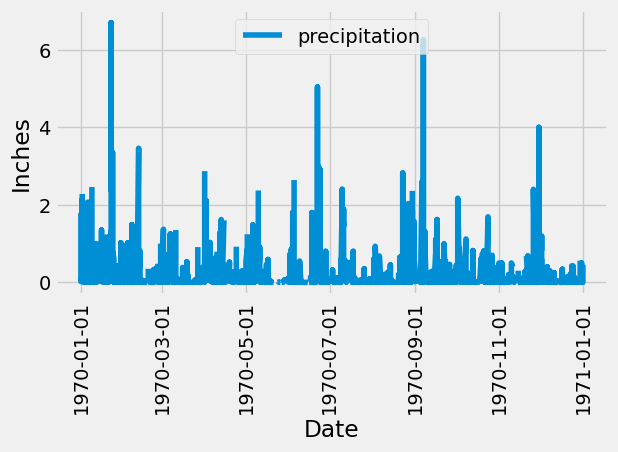

In [111]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['date'], df['precipitation'], label='precipitation')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2nd month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as 'YYYY-MM-DD'

plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [83]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(measurement.station.distinct())).scalar()

9

In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    measurement.station,                                                             
    func.count(measurement.station).label('count')                                     # Count the number of measurements for each station 
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all() # Group the results by station and order the results by count in descending order

# Print the results by looping the query results
for station, count in most_active_stations:
    print(f"({station}, {count})")

(USC00519281, 2772)
(USC00519397, 2724)
(USC00513117, 2709)
(USC00519523, 2669)
(USC00516128, 2612)
(USC00514830, 2202)
(USC00511918, 1979)
(USC00517948, 1372)
(USC00518838, 511)


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

# Query the database for temperature statistics
temperature_stats = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).filter(measurement.station == most_active_station_id).first() # Filter the data to include only the records for the most active station and retrieve the first row

# Unpack the query results into individual variables
min_temp, max_temp, avg_temp = temperature_stats

# Print the temperature statistics as a tuple for clarity
print(f"[({min_temp}, {max_temp}, {avg_temp})]")

[(54.0, 85.0, 71.66378066378067)]


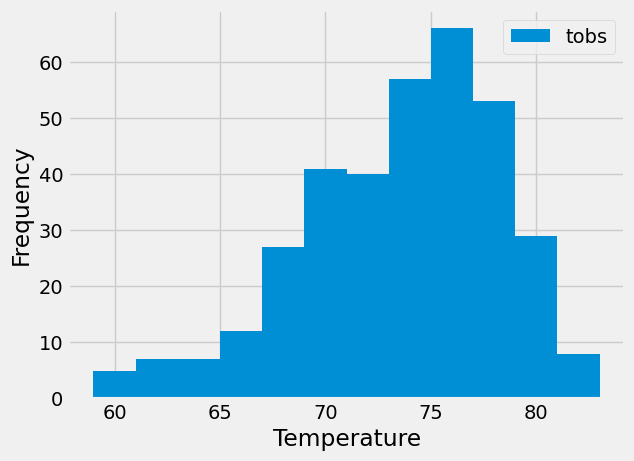

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(measurement.tobs).filter(
    measurement.station == most_active_station_id, # Only include data for the most active station
    measurement.date >= one_year_ago               # Only include data from the last 12 months 
).all() # Retrieve all matching rows as a list of tuples

# Convert the query results into a list of temperature values
temperature_list = [temp[0] for temp in temperatures]

# Plot a histogram of the temperature data
plt.hist(temperature_list, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

# Close Session

In [93]:
# Close Session
session.close()